In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.coreRL.offline_dataset import OfflineDELVEDataset
from survey_ops.utils import units, geometry, interpolate
from survey_ops.utils import ephemerides
from survey_ops.coreRL.data_processing import load_raw_data_to_dataframe

In [3]:
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [4]:
from survey_ops.coreRL.data_processing import relabel_mislabelled_objects, remove_specific_objects, drop_rows_in_DECam_data

In [10]:
def save_bin_and_field_mappings(
    nside,
    objects_to_remove=None,
    specific_years=None, 
    specific_months=None, 
    specific_days=None, 
    specific_filters=None,
    data_fits_fn=None,
    outdir='../data/lookups/',
    bin2radec_fn = 'bin2radec.json',
    bin2azel_fn = 'bin2azel.json',
    field2radec_fn = 'field2radec.json',
    bin2fields_in_bin_fn = 'bin2fields_in_bin.json',
    field2name_fn = 'field2name.json',
    field2nvisits_fn = 'field2maxvisits.json',
):
    if data_fits_fn is None:
        data_fits_fn = '../data/fits/decam-exposures-20251211.fits'
    
    objects_to_remove = ["guide", "DES vvds","J0'","gwh","DESGW","Alhambra-8","cosmos","COSMOS hex","TMO","LDS","WD0","DES supernova hex","NGC","ec", "outlier"]
    df = load_raw_data_to_dataframe(fits_path=data_fits_fn)
    df = drop_rows_in_DECam_data(
        df,
        objects_to_remove=objects_to_remove
    )
    assert len(df) > 0, "No observations found for the specified year/month/day/filter selections."

    # Sort df by timestamp
    df = df.sort_values(by='timestamp').reset_index()

    # convert degrees to radians
    df['el'] = np.pi/2 - df['zd'].values
    df.loc[:, ['ra', 'dec', 'az', 'el', 'zd']] *= units.deg

    hpGrid = ephemerides.HealpixGrid(nside=nside, is_azel=False)
    hpGrid_azel = ephemerides.HealpixGrid(nside=nside, is_azel=True)

    # Add bin column to dataframe
    if hpGrid.is_azel:
        lon = df['az']
        lat = df['el']
        # time x ra, dec --> bin: (az, el)
        # self.bin2fields = lambda time: ephemerides.equatorial_to_topographic(ra=df['az'], dec=df['el'], time=time)
        # raise NotImplementedError
    else:
        lon = df['ra']
        lat = df['dec']
        df['bin'] = hpGrid.ang2idx(lon=lon, lat=lat)

    # Add `field_id` row according to fieldname mapping
    df['field_id'] = pd.factorize(df['object'])[0]
    # df['field_id'] = df['object'].map({v: k for k, v in field2name.items()})

    # Construct mapping from field id to `object` name
    field2name = {fid: g.loc[:, ['object']].values.tolist()[0][0] for fid, g in df.groupby('field_id')}

    # Construct mapping from field id to its respective ra, dec, defined by mean of tilings
    field2radec = {int(fid): (g.loc[:, ['ra', 'dec']]).mean(axis=0).values.tolist() for fid, g in df.groupby('field_id')}
    
    # Only fields with teff > .3 are counted as a visit (as defined by obztak)
        # Fields with *only* teff < .3 have had 0 visits, but should still be present in the dictionary
        # Need a separate history for train vs eval
        # In training, when calculating field tilings, we need a minimum visit of one for all exposures, even if all exposures for a specific field do not meet the teff threshold
            # Otherwise, we get a division by 0 when normalizing by the total tilings thus far
        # In evaluating, we don't want to include exposures with teff < .3 in the visit history since they are not counted as a good enough exposure
    unique_field_ids, u_fid_counts = np.unique(df['field_id'][df['teff'] > .3], return_counts=True)
    field2nvisits_train = {int(fid): 1 for fid in field2radec.keys()} # make sure fields which never have a good teff are at least present in the field2nvisits mapping
    field2nvisits_train.update({int(fid): int(c) for fid, c in zip(unique_field_ids, u_fid_counts)})

    field2nvisits_eval = {int(fid): 0 for fid in field2radec.keys()} # make sure fields which never have a good teff are at least present in the field2nvisits mapping
    field2nvisits_eval.update({int(fid): int(c) for fid, c in zip(unique_field_ids, u_fid_counts)})

    bin2radec = {int(i): (lon, lat) for i, (lon, lat) in zip(hpGrid.heal_idx, zip(hpGrid.lon, hpGrid.lat))}
    bin2azel = {int(i): (lon, lat) for i, (lon, lat) in zip(hpGrid_azel.heal_idx, zip(hpGrid_azel.lon, hpGrid_azel.lat))}
    bin2fields_in_bin = {int(bin_id): g['field_id'].values.tolist() for bin_id, g in df.groupby('bin')}

    night2visithistory = {}
    prev_visit_history = np.zeros(shape=(df['field_id'].max() + 1))
    
    for i, (night, grouped) in enumerate(df.groupby('night')):
        night2visithistory[night] = prev_visit_history.copy()
        mask_teff = grouped['teff'] > .3
        fids, cs = np.unique(grouped['field_id'][mask_teff].values, return_counts=True)
        prev_visit_history[fids] += cs

    with open(outdir + 'DELVE_visit_history.pkl', 'wb') as f:
        pickle.dump(night2visithistory, f)
    
    with open(outdir + f'nside{nside}_' + bin2radec_fn, "w") as f:
        json.dump(bin2radec, f)

    with open(outdir + f'nside{nside}_' + bin2azel_fn, "w") as f:
        json.dump(bin2azel, f)

    with open(outdir + field2radec_fn, "w") as f:
        json.dump(field2radec, f)

    with open(outdir + f'nside{nside}_' + bin2fields_in_bin_fn, "w") as f:
        json.dump(bin2fields_in_bin, f)
        
    with open(outdir + field2name_fn, "w") as f:
        json.dump(field2name, f)

    with open(outdir + 'field2maxvisits_train.json', "w") as f:
        json.dump(field2nvisits_train, f)
        
    with open(outdir + 'field2maxvisits_eval.json', "w") as f:
        json.dump(field2nvisits_train, f)
        
    return df
    

In [14]:
nside=8
# specific_years=[2014]
# specific_months=[12]
# specific_days=[15, 16, 17, 18, 19]
specific_years=None
specific_months = None
specific_days=None

In [15]:
df = save_bin_and_field_mappings(
    nside=nside, 
    specific_years=specific_years, 
    specific_months=specific_months, 
    specific_days=specific_days
)
hpGrid = ephemerides.HealpixGrid(nside=nside, is_azel=True)


In [13]:
visit_history = {}
prev_visit_history = np.zeros(shape=(df['field_id'].max() + 1))

for i, (night, grouped) in enumerate(df.groupby('night')):
    visit_history[night] = prev_visit_history.copy()
    mask_teff = grouped['teff'] > .3
    fids, cs = np.unique(grouped['field_id'][mask_teff].values, return_counts=True)
    prev_visit_history[fids] += cs

In [23]:
with open('../data/lookups/DELVE_visit_history.pkl', 'rb') as f:
    night2visithistory = pickle.load(f)

with open('../data/lookups/field2radec.json', 'r') as f:
    field2radec = json.load(f)

with open(f'../data/lookups/nside{nside}_bin2radec.json', 'r') as f:
    bin2radec = json.load(f)

with open(f'../data/lookups/nside{nside}_bin2azel.json', 'r') as f:
    bin2azel = json.load(f)

with open(f'../data/lookups/nside{nside}_bin2fields_in_bin.json', 'r') as f:
    bin2fields_in_bin = json.load(f)

with open(f'../data/lookups/field2nvisits.json', "r") as f:
    field2nvisits = json.load(f)
    
with open(f'../data/lookups/field2name.json', "r") as f:
    field2name = json.load(f)

In [24]:
visit_history = {}
prev_visit_history = np.zeros(shape=(df['field_id'].max() + 1))

for i, (night, grouped) in enumerate(df.groupby('night')):
    visit_history[night] = prev_visit_history.copy()
    mask_teff = grouped['teff'] > .3
    fids, cs = np.unique(grouped['field_id'][mask_teff].values, return_counts=True)
    prev_visit_history[fids] += cs

In [25]:
for i in range(len(prev_visit_history)):
    if field2nvisits[str(i)] != prev_visit_history[i]:
        print(f"field {i} is not equal")

In [85]:
len(visit_history[list(visit_history.keys())[0]])

16018

In [87]:
list(field2name.keys())[-1]

'16017'

In [88]:
max_len = 0
for fields_list in bin2fields_in_bin.values():
    cur_len = len(fields_list)
    if cur_len > max_len:
        max_len = cur_len

In [89]:
max_len

336

In [91]:
1/336

0.002976190476190476

In [25]:
timestamp = 0

In [123]:
(df['timestamp'].max() - df['timestamp'][df['field_id'] == df['field_id'].max()])/3600

82270    25.630556
Name: timestamp, dtype: float64

In [125]:
df['object'][df['field_id'] == df['field_id'].max()]

82270    DES survey hex 458-674 tiling 9
Name: object, dtype: object

In [120]:
df['timestamp'].max()

1547008747

In [127]:
np.where(df['field_id'].values == fid)[0]

array([82270])

In [132]:
when_first_visit = []
when_complete = []
first_visit_timestamp = []
last_visit_timestamp = []

for fid in df['field_id'].unique():
    first_visit_step = np.where(df['field_id'].values == fid)[0][0]
    completed_visit_step = np.where(df['field_id'].values == fid)[0][-1]
    visit_step = np.where(df['field_id'].values == fid)[0][0]
    first_timestamp = df['timestamp'].values[first_visit_step]
    last_timestamp = df['timestamp'].values[completed_visit_step]
    when_first_visit.append(first_visit_step)
    when_complete.append(completed_visit_step)
    first_visit_timestamp.append(first_timestamp)
    last_visit_timestamp.append(last_timestamp)
    
when_first_vist = np.array(when_first_visit)
first_visit_timestamp = np.array(first_visit_timestamp)
when_complete = np.array(when_complete)
last_visit_timestamp = np.array(last_visit_timestamp)

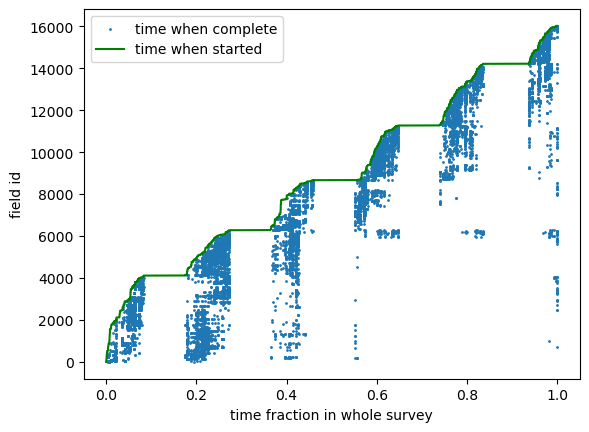

In [149]:
plt.scatter((last_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min()), np.arange(len(last_visit_timestamp)), s=1, label='time when complete')
plt.ylabel('field id')
plt.xlabel('time fraction in whole survey')

plt.scatter((first_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min()), np.arange(len(last_visit_timestamp)), color='green', label='time when started')
plt.legend()

In [155]:
time_to_complete = ((last_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min())) - ((first_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min()))

Text(0, 0.5, 'time to complete')

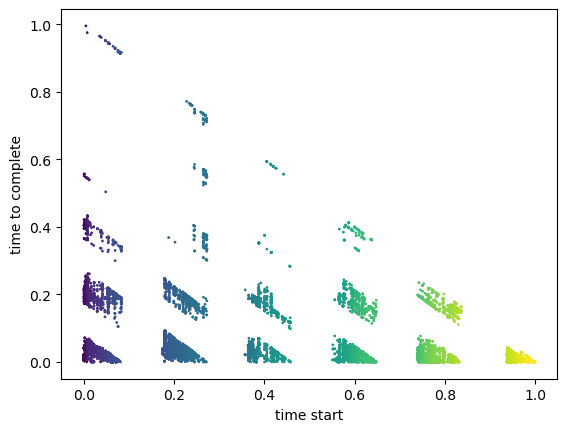

In [166]:
plt.scatter((first_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min()), time_to_complete, c=np.arange(len(time_to_complete)), s=1)
plt.xlabel('time start')
plt.ylabel('time to complete')

(array([10383.,  3722.,  1397.,   264.,    95.,    66.,     0.,    56.,
            0.,    35.]),
 array([0.        , 0.09956796, 0.19913592, 0.29870388, 0.39827184,
        0.4978398 , 0.59740776, 0.69697572, 0.79654368, 0.89611164,
        0.9956796 ]),
 <BarContainer object of 10 artists>)

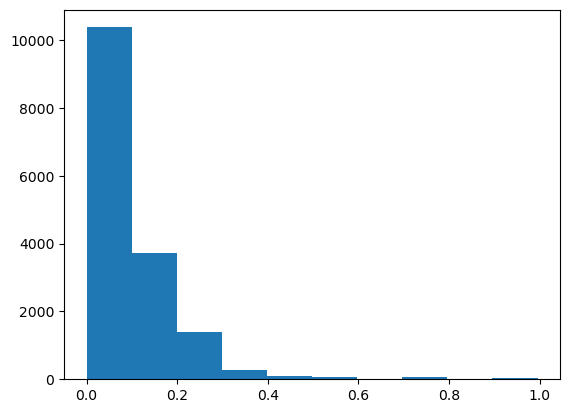

In [161]:
plt.hist(time_to_complete)

Text(0, 0.5, 'Field id')

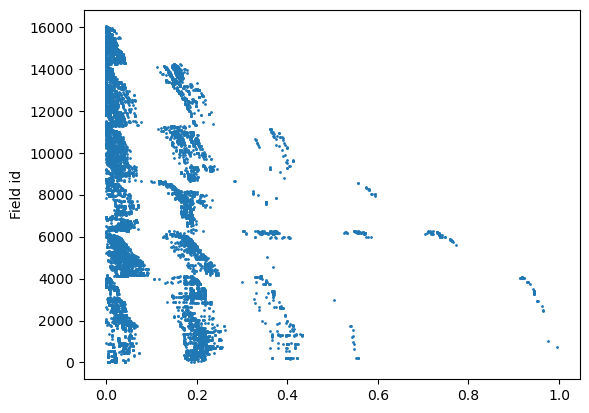

In [160]:
plt.scatter(time_to_complete, np.arange(len(time_to_complete)), s=1)
plt.ylabel('Field id')

Text(0.5, 0, 'time when complete')

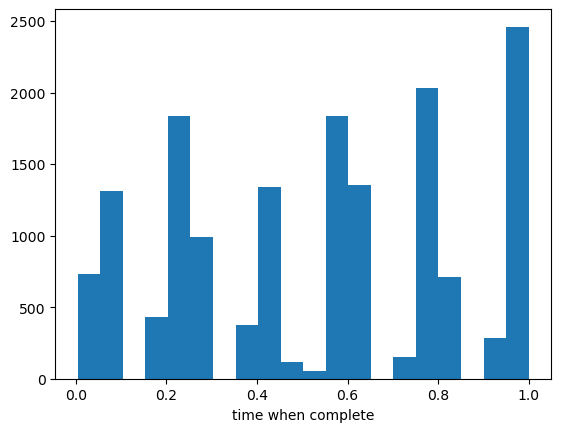

In [147]:
plt.hist((last_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min()), bins=20)
plt.xlabel("time when complete")

Text(0.5, 1.0, 'First time visited')

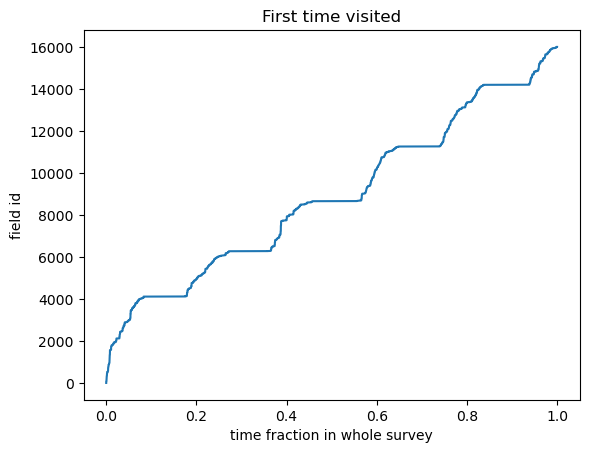

In [141]:
plt.plot((first_visit_timestamp - df['timestamp'].min()) / (df['timestamp'].max()- df['timestamp'].min()), np.arange(len(last_visit_timestamp)))
plt.ylabel('field id')
plt.xlabel('time fraction in whole survey')
plt.title('First time visited')

In [40]:
fieldradecs = np.array([[ra, dec] for ra, dec in field2radec.values()])
_az, _el = ephemerides.equatorial_to_topographic(ra=fieldradecs[:, 0], dec=fieldradecs[:, 1], time=timestamp)
fieldazels = np.array([_az, _el]).T
# Get bin membership of all fields at this time
field_bins = hpGrid.ang2idx(lon=fieldazels[:, 0], lat=fieldazels[:, 1])
bins_with_fields = np.unique(field_bins)
for bid in bins_with_fields:
    fids = np.where(field_bins == bid)[0]
    min_tiling = np.array([field2nvisits[str(fid)] for fid in fids]).min()
    print(min_tiling)

1
2
1
2
1
1
2
2
1
2
1
1
2
1
2
2
2
2
1
1
1
1
1
2
1
1
1
1
2
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
2
1
1
1
1
3
1
1
1
2
2
3
3
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
2
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
2
1
2
1
2
2
1
1
2
4
4
5
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
2
2
1
3
2
1
5
4
1
1
1
1
1
2
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
2
2
2
1
3
2
3
3
3
3
3
1
1
1
1
1
2
5
1
3
1
1
1
1
1
2
1
1
3
1
3
2
1
1
3
2
3
3
3
3
4
2
1
3
3
4
4
1
1
1
1
3
4
2
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
3
1
3
3
4
4
3
1
1
1
2
2
4
4
3
4
1
2
3
1
1
2
1
3
3
1
2
1
1
1
1
4
3
3
1
4
2
2
1
1
1
4
4
3
2
2
2
1
2
3
1
2
3
1
1
1
4
4
4
3
3
2
1
1
1
1
2
4
3
3
2
2
1
2
1
1
2
2
3
1
3
2
2
3
1
4
4
1
1
1
3
2
3
2
2
1
1
2
2
1
2
2
4
3
1
1
1
2
4
4
1
4
3
3
1
2
1
2
1
1
2
1
2
3
2
1
2
1
4
4
4
1
5
4
2
4
3
1
3
1
1
4
2
3
1
4
3
4
4
4
1
1
1
1
1
1
1
1
2
3
3
1
1
2
3
4
1
1
1
1
1
1
1
3
2
1
1
3
4
1
1
1
1
1
1
1
4
3
3
3
2
3
1
1
1
1
1
1
3
3
4
4
3
4
1
1
4
4
4
3
1
1
1
1
4
3
1
1
5
4
1
1
3


array([903, 903, 902, ..., 336, 389, 336], shape=(15966,))

In [ ]:

def get_fields_in_bin(bin_num, is_azel, timestamp, field2nvisits, field_ids, field_radecs, hpGrid, visited, bin2fields_in_bin=None):
    if is_azel:
        mask_completed_fields = np.array([visited[fid] < field2nvisits[fid] for fid in field_ids], dtype=bool)
        fields_az, fields_el = ephemerides.equatorial_to_topographic(ra=field_radecs[:, 0], dec=field_radecs[:, 1], time=timestamp)
        mask_fields_below_horizon = fields_el > 0
        field_bins = hpGrid.ang2idx(lon=fields_az, lat=fields_el)
        # valid fields are fields in bin and fields which have not been completed
        sel_valid_fields = (field_bins == bin_num) & mask_fields_below_horizon & mask_completed_fields
        fields_in_bin = field_ids[sel_valid_fields]
    else:
        bin_num = str(bin_num)
        fields_in_bin = bin2fields_in_bin.get(bin_num)
        sel_valid_fields = np.array([visited[fid] < field2nvisits[fid] for fid in fields_in_bin], dtype=bool)
        fields_in_bin = np.array(fields_in_bin)[sel_valid_fields]
    return fields_in_bin
